In [3]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = web.DataReader('AAPL', data_source = 'yahoo', start='2012-01-01', end='2019-12-17')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792


In [6]:
df.shape

(2003, 6)

C:\Program Files\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Close Price USD ($)')

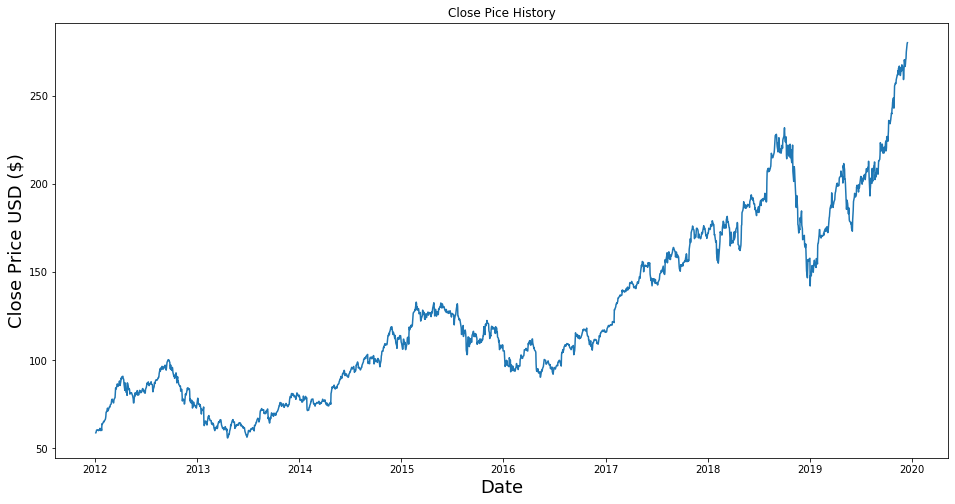

In [7]:
#Visualize the closing price history

plt.figure(figsize=(16,8))
plt.title('Close Pice History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

In [8]:
# Create new dataFrame with only the close column
data = df.filter(['Close'])
# convert data no np array
dataset = data.values
# get the number of rows to train LSTM
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

1603

In [9]:
# Scale the Data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [11]:
# Training Dataset
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.01316509, 0.01457064, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862193, 0.02173194,
       0.02453668, 0.02367172, 0.01893356, 0.02345548, 0.01900352,
       0.03569838, 0.03440731, 0.0360927 , 0.03973694, 0.04194384,
       0.0417594 , 0.0410789 , 0.04397903, 0.04670744, 0.04979839,
       0.05479095, 0.0652785 , 0.06543749, 0.07127594, 0.07563885,
       0.06814046, 0.07102789, 0.07097066, 0.07906688, 0.07791571,
       0.08004628, 0.08387497, 0.08600558, 0.09214292, 0.09661397,
       0.09790501, 0.09835659, 0.09071194, 0.08886753, 0.08914103,
       0.09632775, 0.09835024, 0.10269405, 0.11293358, 0.12659476,
       0.12403805, 0.1240444 , 0.13392141, 0.13701233, 0.13481179,
       0.13280207, 0.13070964, 0.13766105, 0.14243103, 0.14442805])]
[0.13949272033425864]



In [12]:
# Convert to np array
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
# Reshape the data [numsamples, numtimesteps, numfeatures]

x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1543, 60, 1)

In [15]:
# Build the LSTM Model

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))


In [16]:
# Compile the Model

model.compile(optimizer='adam', loss = 'mean_squared_error')

In [17]:
# Train the Model

model.fit(x_train, y_train, batch_size=1, epochs=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
1543/1543 [==============================] - 256s 166ms/step - loss: 0.0010


In [18]:
#Creat the Test Dataset

test_data = scaled_data[training_data_len-60:2003, :]

# X_test, Y_test

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    


In [19]:
# Convert to np array

x_test = np.array(x_test)

In [20]:
# reshape the data

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [21]:
# Predict the price

predictions = model.predict(x_test)

predictions = scaler.inverse_transform(predictions)

In [22]:
# Get the RMSE

rmse = np.sqrt(np.mean(predictions-y_test)**2)

rmse

10.079944076538085

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


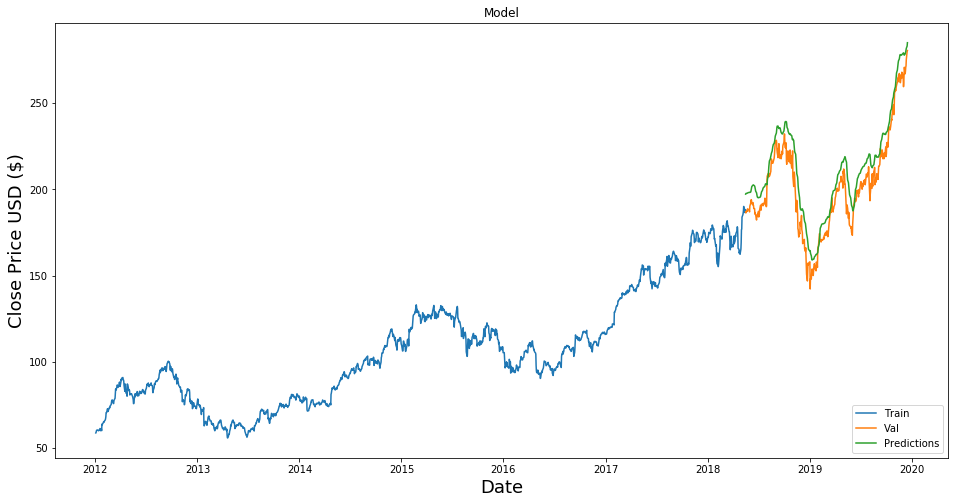

In [26]:
# Visualize the data

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')

In [28]:
# Show the valid and predicted data

valid

,Close,Predictions
Date,,
2018-05-17,186.990005,197.174561
2018-05-18,186.309998,197.555023
2018-05-21,187.630005,197.640076
2018-05-22,187.160004,197.718933
2018-05-23,188.360001,197.726151
2018-05-24,188.149994,197.838516
2018-05-25,188.580002,197.964996
2018-05-29,187.899994,198.137650
2018-05-30,187.500000,198.235428


In [ ]:
apple_quote = web.DataReader('APPL', data_source='yahoo', )